In [43]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
from scipy.interpolate import interp1d
import pandas_profiling
import cufflinks as cf
import plotly.offline
import random

In [44]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [54]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
#     plt.ylim(60,100)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

### 导入数据

In [46]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)

In [47]:
df3 = df.copy(deep=True) 
# df3 = df2[0:100]
# plot_df(df3, x=df3.index, y= df3["内存负载"], title='Memory load____Ture')

In [48]:
# 数据的Profiling过程
# profile = pandas_profiling.ProfileReport(df)
# profile.to_file("Server performance data profiling.html")

In [49]:
# 交互式图
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
# df["内存负载"].iplot()

In [50]:
df.loc[23,"日期"]

'2020-03-02 00:00:00'

In [51]:
df["内存负载"].isnull().any()

True

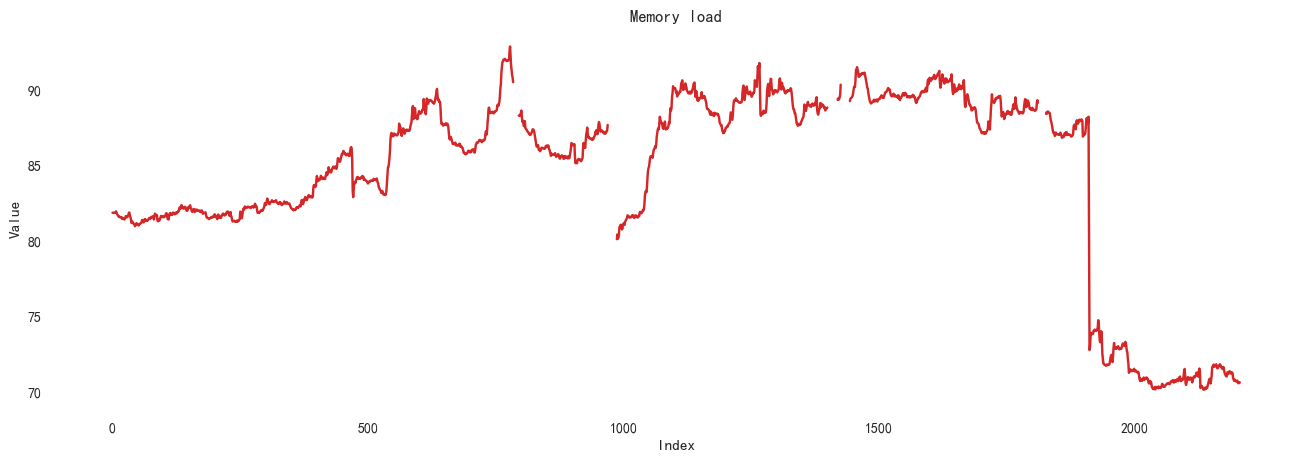

In [52]:
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

### 缺失值填充

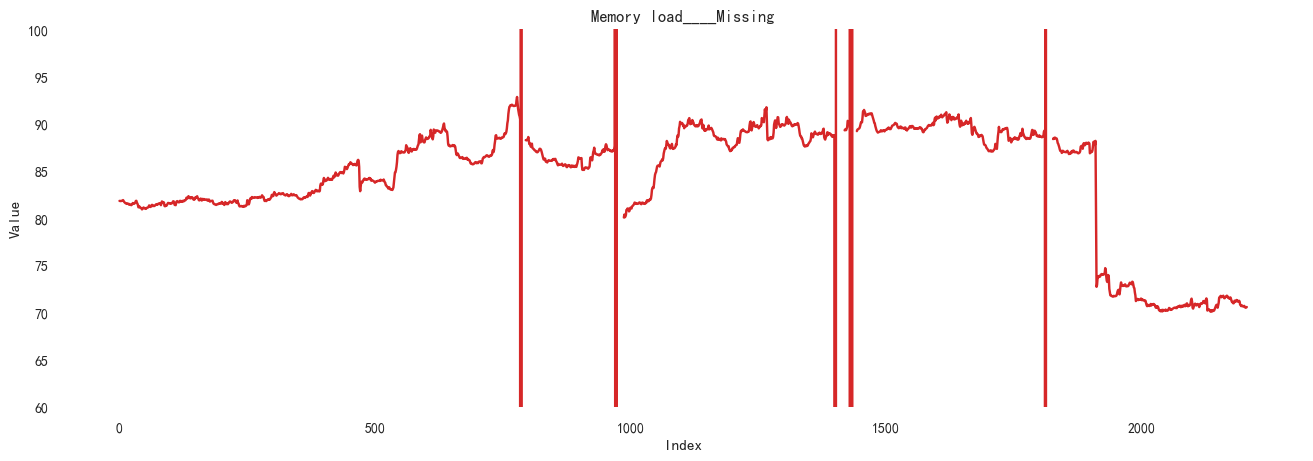

D:\Softwore\python38\lib\site-packages\numpy\lib\polynomial.py:736: RuntimeWarning:

invalid value encountered in double_scalars

D:\Softwore\python38\lib\site-packages\numpy\lib\polynomial.py:794: RuntimeWarning:

invalid value encountered in add



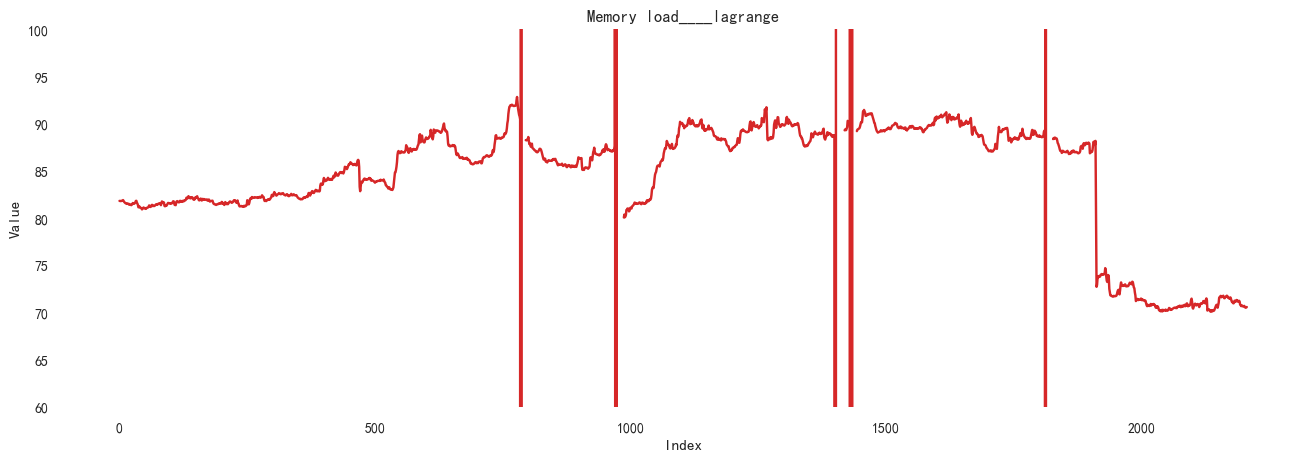

In [55]:
# 拉格朗日插值法
# num = random.sample(range(0, 100), 5)
# for i in num:
#     df3["内存负载"][i] = np.nan
series = df3["内存负载"]
plot_df(df3, x=df3.index, y= series, title='Memory load____Missing')
def ployinterp_column(s, n, k=24):
    y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))]
    y = y[y.notnull()]
    return lagrange(y.index, list(y))(n)

def lagrange(x, w):
    M = len(x)
    p = 0.0
    for j in range(M):
        pt = w[j]
        for k in range(M):
            if k == j:
                continue
            fac = x[j]-x[k]
            pt *= np.poly1d([1.0, -x[k]])/fac
        p += pt
    return p
for i in range(len(df3)):
    if (df3['内存负载'].isnull())[i]:
        df3['内存负载'][i] = ployinterp_column(df3['内存负载'], i)
plot_df(df3, x=df3.index, y= df3["内存负载"], title='Memory load____lagrange')

In [12]:
# 方法一 Forward Fill 向前填充
# df_ffill = df.ffill()
# df_ffill
# plot_df(df_ffill, x=df_ffill.index, y= df_ffill["内存负载"], title='Memory load____Forward Fill')

In [13]:
# 方法二 Backward Fill 向后填充
# df_bfill = df.bfill()
# plot_df(df_bfill, x=df_bfill.index, y= df_bfill["内存负载"], title='Memory load____Backward Fill')

In [14]:
# 方法三 Linear Interpolation
# df['rownum'] = np.arange(df.shape[0])
# df_nona = df.dropna(subset = ['内存负载'])
# f = interp1d(df_nona['rownum'], df_nona['内存负载'])
# df['linear_fill'] = f(df['rownum'])
# plot_df(df, x=df.index, y= df["linear_fill"], title='Memory load____Linear Interpolation')

In [15]:
# 方法四 Cubic Interpolation
# f2 = interp1d(df_nona['rownum'], df_nona['内存负载'], kind='cubic')
# df['cubic_fill'] = f2(df['rownum'])
# plot_df(df, x=df.index, y= df['cubic_fill'], title='Memory load____Cubic Interpolation')

In [16]:
# 方法五 Seasonal Mean
# def seasonal_mean(ts, n, lr=0.7):
#     """
#     Compute the mean of corresponding seasonal periods
#     ts: 1D array-like of the time series
#     n: Seasonal window length of the time series
#     """
#     out = np.copy(ts)
#     for i, val in enumerate(ts):
#         if np.isnan(val):
#             ts_seas = ts[i-1::-n]  # previous seasons only
#             if np.isnan(np.nanmean(ts_seas)):
#                 ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
#             out[i] = np.nanmean(ts_seas) * lr
#     return out
# df['seasonal_mean'] = seasonal_mean(df["内存负载"], n=168, lr=1)
# plot_df(df, x=df.index, y= df['seasonal_mean'], title='Memory load____Seasonal Mean')

In [17]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

In [18]:
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)

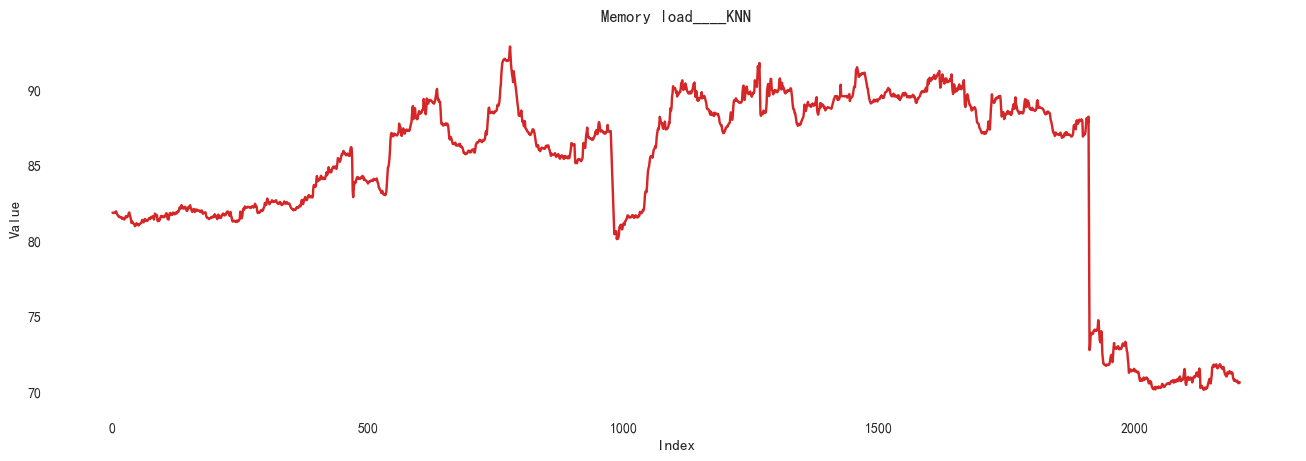

In [19]:
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load____KNN')

### 周期性观察

In [20]:
df['DATA_DT'][0:2207].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206],
           dtype='int64', length=2207)

In [21]:
# 周期性显示从3月2号星期一开始[0:2207],总计12周
df_freq = pd.DataFrame(index= df['DATA_DT'][0:2207].index)
df_freq['天数'] = [f'第{int(d/24) +1}天' for d in df['DATA_DT'][0:2207].index]
df_freq['小时']=[f'{(d)%24 + 1}' for d in df['DATA_DT'][0:2207].index]
df_freq['values'] = df['内存负载'][0:2207]
df_freq

,天数,小时,values
0,第1天,1,81.8242
1,第1天,2,81.8145
2,第1天,3,81.8092
3,第1天,4,81.8042
4,第1天,5,81.8333
...,...,...,...
2202,第92天,19,70.6183
2203,第92天,20,70.5208
2204,第92天,21,70.5608
2205,第92天,22,70.5292


In [22]:
week_num = df_freq['天数'].unique()

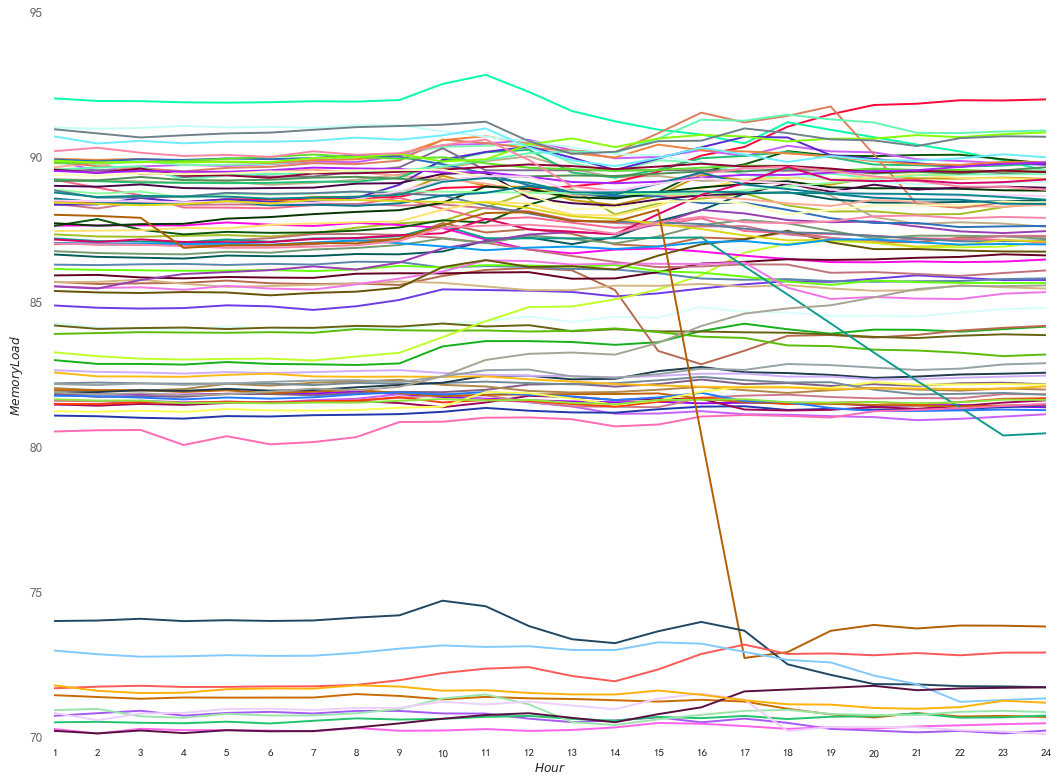

In [23]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(week_num), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(week_num[0:-1]):
    plt.plot('小时', 'values', data=df_freq[df_freq["天数" ]== y], color=mycolors[i], label=y)
#         plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(0, 23), ylim=(70, 95), ylabel='$Memory Load$', xlabel='$Hour$')
plt.yticks(fontsize=12, alpha=.7)
# plt.title("内存负载时间序列的日周期图", fontsize=20)
plt.show()

In [24]:
# plot_acf(df["内存负载"],).show() #延迟数

### 平滑

In [25]:
from scipy.interpolate import UnivariateSpline
from numpy import linspace,exp
from numpy.random import randn
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess

In [26]:
# # 样条平滑方法
# x = np.array(df.index)
# y = np.array(df["内存负载"])
# s = UnivariateSpline(x,y,s=1)
# xs = np.array(df.index)
# tmp_smooth = s(xs)
# plt.plot(xs[100:150],tmp_smooth[100:150])

In [27]:
# # Savitzky-Golay平滑滤波
# plt.figure(figsize=(16,5), dpi=100)
# x = np.array(df.index)
# tmp_smooth0 = scipy.signal.savgol_filter(df["内存负载"],5,3)
# tmp_smooth1 = scipy.signal.savgol_filter(df["内存负载"],7,3)
# tmp_smooth2 = scipy.signal.savgol_filter(df["内存负载"],11,3)
# plt.plot(df["内存负载"][100:200],label = '原始值',color = 'black')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth0[100:200],label = '平滑曲线-5',color = 'red')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth1[100:200],label = '平滑曲线-7',color = 'blue')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth2[100:200],label = '平滑曲线-11',color = 'green')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [28]:
# plt.figure(figsize=(16,5), dpi=100)
# x = np.array(df.index)
# tmp_smooth0 = scipy.signal.savgol_filter(df["内存负载"],9,3)
# tmp_smooth1 = scipy.signal.savgol_filter(df["内存负载"],9,5)
# tmp_smooth2 = scipy.signal.savgol_filter(df["内存负载"],9,7)
# plt.plot(df["内存负载"][100:200],label = '原始值',color = 'black')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth0[100:200],label = '平滑曲线-3',color = 'red')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth1[100:200],label = '平滑曲线-5',color = 'blue')
# plt.plot(df["内存负载"][100:200].index,tmp_smooth2[100:200],label = '平滑曲线-7',color = 'green')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [29]:
len(tmp_smooth0)

NameError: name 'tmp_smooth0' is not defined

In [ ]:
# # Moving Average
# plt.figure(figsize=(16,5), dpi=100)
# df_ma = df["内存负载"].rolling(3).mean()
# df_ma1 = df["内存负载"].rolling(5).mean()
# df_ma2 = df["内存负载"].rolling(10).mean()
# plt.plot(df["内存负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_ma[100:200],label = '平滑曲线：k=3',color = 'red')
# plt.plot(df_ma1[100:200],label = '平滑曲线：k=5',color = 'blue')
# plt.plot(df_ma2[100:200],label = '平滑曲线：k=10',color = 'green')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [ ]:
# # plt.figure(figsize=(16,5), dpi=100)
# plt.plot(df["内存负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_ma1[100:200],label = '拟合曲线：k=5',color = 'red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [ ]:
# plt.plot(df["内存负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_ma2[100:200],label = '拟合曲线：k=10',color = 'red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [ ]:
# Loess Smoothing (5% and 15%)
# plt.figure(figsize=(16,5), dpi=100)
# df_loess_5 = pd.DataFrame(lowess(df["内存负载"], np.arange(len(df["内存负载"])), frac=0.002)[:, 1], index=df["内存负载"].index, columns=['内存负载'])
# df_loess_15 = pd.DataFrame(lowess(df["内存负载"], np.arange(len(df["内存负载"])), frac=0.015)[:, 1], index=df["内存负载"].index, columns=['内存负载'])
# plt.plot(df["内存负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_loess_5[100:200],label = '平滑曲线__frac=0.002',color = 'red')
# plt.plot(df_loess_15[100:200],label = '平滑曲线__frac=0.015',color = 'blue')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [ ]:
# # 转化为Series
# temp_Series = pd.Series(tmp_smooth1,
#                        index=x,
#                        name="内存负载")

In [ ]:
temp_Series =df["内存负载"]

In [ ]:
df.loc[1973]

In [ ]:
temp_Series.isnull().any()

In [ ]:
# plt.plot(temp_Series[1445:1457])

### 去除季节性因素

In [ ]:
# result_mul = sm.tsa.seasonal_decompose(temp_Series, model='multiplicative',period = 168, extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
# result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
# plot_df(result_mul.resid[0:400], x=result_mul.resid.index[0:400], y= result_mul.resid[0:400], title='Mul_resid')

In [ ]:
result_add = sm.tsa.seasonal_decompose(temp_Series, model='additive',period = 24, extrapolate_trend='freq')
result_add.plot().suptitle('Additive Decompose', fontsize=22)

In [ ]:
plot_df(result_add.resid, x=result_add.resid.index, y= result_add.resid, title='Add_resid')

In [ ]:
# rd = sm.tsa.seasonal_decompose(temp_Series,period=24)
# resplot = rd.plot()

In [ ]:
# 周期值24
a = result_add.seasonal
season = []
for i in range(24):
    season.append(a[i])
plot_df(df, x=range(24), y= season, title='Add_resid')

In [ ]:
arr = temp_Series - result_add.seasonal
type(arr)

In [ ]:
train =arr[1704:2040]
train

In [ ]:
test = arr[2040:2052]
test

In [ ]:
# 定阶后的单步预测
model = sm.tsa.ARIMA(train, order=(1, 1, 3))
result = model.fit()
te = result.forecast(12)[0]
te

In [ ]:
# 迭代预测方法
train_temp = train
error = []
truth = []
for i in range(len(test)):
    if len(error) != 0:
#         train_temp = train_temp[1:].append(pd.Series(error[i-1]))
        train_temp = train_temp.append(pd.Series(error[i-1]))
#         print(train_temp)
    model = sm.tsa.ARIMA(train_temp, order=(1, 1, 3))
    result = model.fit()
    te = result.forecast()[0]
    error.append(te[0])
error

In [ ]:
error_net = [-0.02594328671693802,
 -0.04000457376241684,
 -0.04611435532569885,
 -0.044208675622940063,
 -0.0337812677025795,
 -0.028292324393987656,
 -0.027750998735427856,
 -0.038270678371191025,
 -0.06296169757843018,
 -0.06944025307893753,
 -0.07597356289625168,
 -0.07414025068283081]
temp = []
temp2 = []
for i in range(len(te)):
    temp.append(te[i] + season[6+i] ) 
for i in range(len(error)):
    temp2.append(te[i] + season[6+i] + error_net[i]) 
temp

In [ ]:
y_1 = df["内存负载"][2046:2058]
# 迭代策略
# 模型输入数据集长度不变
y_2 = temp
# 模型过去一周训练,变长预测
y_3 = temp2
# # 直接策略
# y_3 = [88.76133487,88.67568213,88.80482849,
#        88.82377398,89.87014746,89.68174806,90.31510764,88.94456323,89.2641398,89.53729765]
# # 神经网络
# y_4 = [88.5779,88.3317,88.394,88.3592,88.4777,88.8119,88.843,89.0937,88.8181,88.6788]
x = range(len(test))
 
#设置图形大小
plt.figure(figsize=(20,8),dpi=80)
# color可以百度颜色代码
plt.plot(x,y_1,label="truth",color="black")
plt.plot(x,y_2,label="pre1",color="red",linestyle="--")
plt.plot(x,y_3,label="pre2",color="blue",linestyle="--")
plt.ylim(70,71)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')

#展示
plt.show()

In [ ]:
MSE = 0
for i in range(12):
    MSE += (temp[i] - df["内存负载"].loc[2046+i])**2
MSE

In [ ]:
MSE = 0
for i in range(12):
    MSE += (temp2[i] - df["内存负载"].loc[2046+i])**2
MSE

### 差分

In [ ]:
# 差分法生成序列
dif = []
dif = train.diff(1)

In [ ]:
plt.plot(dif)

In [ ]:
type(dif)

### ADF检验

In [ ]:
timeSeries = dif[1:]
adftest = ts.adfuller(timeSeries)
adftest

### 白噪声检验

In [ ]:
acorr_ljungbox(timeSeries, lags=1)

In [ ]:
# 一阶差分后p值远小于0.05,因此差分后的序列是平稳非白噪声序列

In [ ]:
plot_acf(timeSeries).show()

In [ ]:
plot_pacf(timeSeries).show()

In [ ]:
timeSeries

### ACF定阶

In [ ]:
#画图定阶

In [ ]:
# ACF和PACF定阶
#利用ACF和PACF判断模型阶数
# plot_acf(arr).show() #延迟数

In [ ]:
# plot_pacf(arr).show()

In [ ]:
#设置遍历循环的初始条件，以热力图的形式展示，跟AIC定阶作用一样
p_min = 1
q_min = 3
p_max = 5
q_max = 7
d_min = 0
d_max = 1

In [ ]:
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
results_bic

In [ ]:
import statsmodels.api as sm
import itertools
import seaborn as sns

In [ ]:
# timeSeries = pd.Series(arr)
# type(timeSeries)

In [ ]:
num = 1
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
#                                enforce_stationarity=False,
#                                enforce_invertibility=False,
                              )
        results = model.fit()
        num += 1
        print(f"循环{num}次")
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')

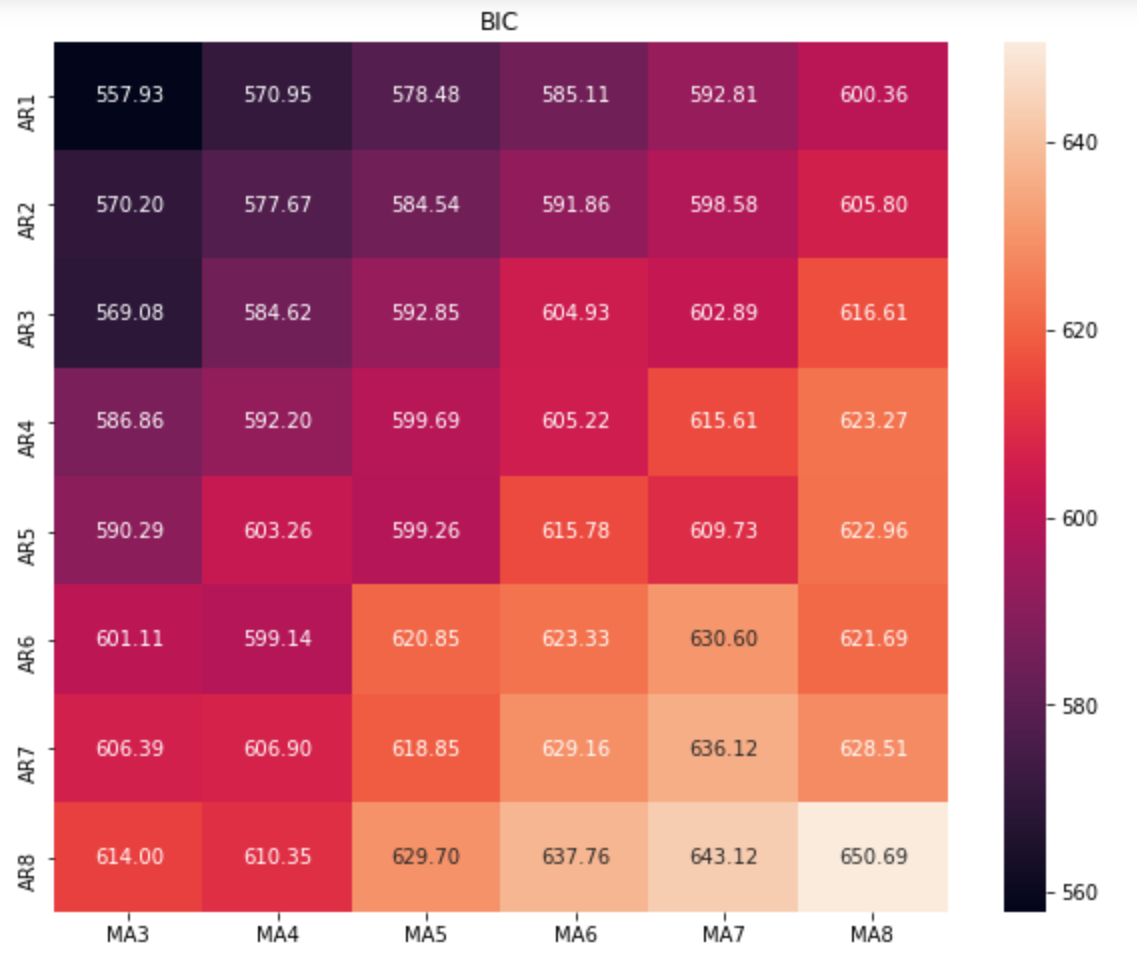

### LB残差检验

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

In [ ]:
result = lb_test(timeSeries, lags=12)
print(result[1])

In [ ]:
plt.plot(range(len(result[1])), result[1])

In [ ]:
model = sm.tsa.ARIMA(df["内存负载"], order=(1, 1, 2))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)

In [ ]:
model = sm.tsa.ARIMA(df["内存负载"], order=(1, 1, 2))
result = model.fit()

In [ ]:
result.forecast()[0]

In [ ]:
import matplotlib
print(matplotlib.get_configdir())